In [55]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import qgrid
from skimpy import clean_columns
import lightgbm as lgb
import matplotlib as plt
import shap
shap.initjs()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

In [3]:
# Import voting data
d_voters_raw = pd.read_excel(
    "../data/nz/elections-nz/2020-General-Election-full-voter-turnout-statistics.xlsx", 
    sheet_name="Voting by age & descent",
    header=4
)

In [4]:
qgrid.show_grid(d_voters_raw, grid_options={'forceFitColumns': False, 'showToolbar': True})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [8]:
# clean column names
d_voters_proc = clean_columns(d_voters_raw)

In [9]:
qgrid.show_grid(d_voters_proc, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [10]:
# filter for numbered electorates only
d_voters_proc = (
    d_voters_proc
    .loc[pd.to_numeric(d_voters_proc['electorate_number'], errors='coerce').notnull()]
)

In [11]:
qgrid.show_grid(d_voters_proc, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [12]:
# import imd data
d_imd_raw = pd.read_excel("../data/nz/IMD2018.xlsx", sheet_name="IMD18")
d_imd_raw = clean_columns(d_imd_raw)

In [13]:
qgrid.show_grid(d_imd_raw, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [14]:
qgrid.show_grid(d_imd_raw[['ta_2020name', 'rnk_imd_no_inc', 'rank_incom']], grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [15]:
#group by electorates for joining to voting data, take weighted averages of features by population
# TO DO: Better pandas code for this surely
d_imd_proc = (
    d_imd_raw
    .groupby('ged_2020_id')
    .apply(lambda x: pd.Series({
        'population': x['census_18_pop'].sum(),
        'imd_18_dec': np.average(x.dec_imd_18, weights=x.census_18_pop),
        'imd_18_rank': np.average(x.rank_imd_18, weights=x.census_18_pop),
        'emp_dec': np.average(x.decile_emp, weights=x.census_18_pop),
        'emp_rank': np.average(x.rank_emplo, weights=x.census_18_pop),
        'income_dec': np.average(x.decile_inc, weights=x.census_18_pop),
        'income_rank': np.average(x.rank_incom, weights=x.census_18_pop),
        'income_dec_no': np.average(x.rnk_imd_no_inc, weights=x.census_18_pop),
        'health_dec': np.average(x.decile_hea, weights=x.census_18_pop),
        'health_rank': np.average(x.rank_healt, weights=x.census_18_pop),
        'edu_dec': np.average(x.decile_edu, weights=x.census_18_pop),
        'edu_rank': np.average(x.rank_educa, weights=x.census_18_pop)
    }))
)

In [16]:
qgrid.show_grid(d_imd_proc)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [32]:
# join voters data with IMD data
d_train = (
    d_voters_proc
    .merge(d_imd_proc, how = "left", left_on = "electorate_number", right_on = "ged_2020_id")
    .dropna(subset = ['population'])
)

In [33]:
qgrid.show_grid(d_train, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [264]:
#select features - categorical features needed to be flagged for model
l_features_num = ['emp_dec', 'income_dec', 'health_dec', 'edu_dec']
l_features_cat = ['voter_designation_by_descent', 'age_band']
l_target = ['voters_as_%_of_total_enrolled']
#d_weight = d_train['total_enrolled']
d_weight = d_train.total_enrolled.to_numpy()
l_all = l_features_num + l_features_cat

In [35]:
d_train[l_all].dtypes

emp_dec                         float64
income_dec                      float64
health_dec                      float64
edu_dec                         float64
voter_designation_by_descent     object
age_band                         object
dtype: object

In [267]:
d_weight

array([5155.,  442., 4658., ...,  121., 6723.,  191.])

In [184]:
#d_train.isna().sum()
n_average_turnout = np.average(d_train['voters_as_%_of_total_enrolled'], weights=d_train.population)
print(n_average_turnout)

0.8079991431953041


In [40]:
# categorical features need to be category types instead of strings ("object")
for c in l_features_cat:
    d_train[c] = d_train[c].astype('category')

In [269]:
#Single model training
# # prep data set ready for training
# # weights for higher population electorates - low pop causes larger swing in %ages
# lgb_train = lgb.Dataset(
#     data = d_train[l_all], 
#     categorical_feature = l_features_cat,
#     label = d_train[l_target],
#     weight = d_weight,
#     init_score = n_average_turnout,
#     free_raw_data = False
# )
# # parameter settings - L1 norm for decimal issues, randomly picked depth/LR/iterations for now.
# lgb_param = {
#     'num_leaves': 10, 
#     'learning_rate': 0.2,
#     'num_iterations': 50,
#     'objective': 'regression', 
#     'metric': 'mae',
#     'verbose_eval': 1}
# # train lgb model
# lgb_mod = lgb.train(
#     params = lgb_param, 
#     train_set = lgb_train, 
#     valid_names=[lgb_train], 
#     categorical_feature=l_features_cat)

In [272]:
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X = d_train[l_all], y = d_train[l_target])

In [273]:
# param_grid = {
#     'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'min_data_in_leaf': [30, 50, 100, 300, 400],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1]
#     }
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'num_leaves': [10, 20, 50, 100],
    'min_data_in_leaf': [10, 30, 50],
    'num_iterations': [100, 200]
    }

In [274]:
lgb_estimator = lgb.LGBMRegressor(
    num_iterations = 50,
    categorical_feature = l_features_cat,
    objective = 'mae',
    metric = 'mae',
    init_score = n_average_turnout,
    sample_weight = d_weight
)

In [275]:
gsearch = GridSearchCV(
    estimator = lgb_estimator, 
    param_grid = param_grid, 
    cv=gkf)

In [276]:
lgb_model = gsearch.fit(X = d_train[l_all], y = d_train[l_target])

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: init_score
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter

In [277]:
print(lgb_model.best_params_, lgb_model.best_score_)

{'learning_rate': 0.3, 'min_data_in_leaf': 10, 'num_iterations': 200, 'num_leaves': 10} 0.8860068838818125


In [278]:
lgb_model.best_estimator_

LGBMRegressor(categorical_feature=['voter_designation_by_descent', 'age_band'],
              init_score=0.8079991431953041, learning_rate=0.3, metric='mae',
              min_data_in_leaf=10, num_iterations=200, num_leaves=10,
              objective='mae',
              sample_weight=array([5155.,  442., 4658., ...,  121., 6723.,  191.]))

In [279]:
# refit with best params for stupid SHAP package
lgb_mod = lgb_model.best_estimator_.fit(X = d_train[l_all], y = d_train[l_target])

In [280]:
# predict, print error, save predictions
d_out = d_train[l_all + l_target]
d_out['preds'] = lgb_mod.predict(d_train[l_all])
d_out['error'] = np.abs(d_out['preds'] - d_out['voters_as_%_of_total_enrolled'])
np.sum(d_out['error'])

15.735082490621854

In [281]:
#shap_values = lgb_mod.predict(d_train[l_all], pred_contrib=True)
shap_values = shap.TreeExplainer(lgb_mod).shap_values(d_train[l_all])
shap_values

array([[ 0.00644755,  0.02258577, -0.00048185,  0.02722616,  0.0040544 ,
        -0.01184755],
       [ 0.00926763,  0.02986269,  0.00276056,  0.04379106, -0.0040544 ,
        -0.01626857],
       [ 0.00879958,  0.02116234,  0.00271236,  0.02465165,  0.00450606,
        -0.03699765],
       ...,
       [-0.00243825,  0.00242454, -0.00905817,  0.00562377, -0.01277416,
         0.06418126],
       [-0.00312117,  0.00528255, -0.00992934,  0.01080913,  0.01310563,
         0.0377689 ],
       [-0.00091856,  0.00325659, -0.01040337,  0.00791808, -0.01310563,
         0.04000959]])

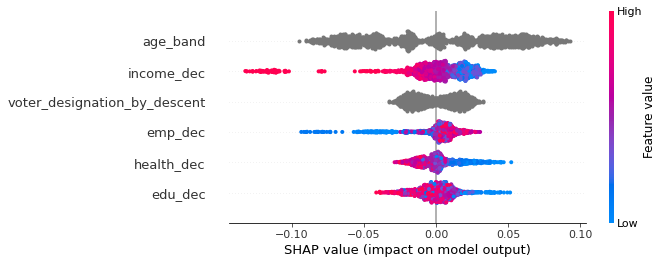

In [282]:
# Shows the single factor correlation of feature contributions (SHAP Values)
# Makes sense but need to check why employment is opposite correlation?
shap.summary_plot(shap_values, d_train[l_all])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

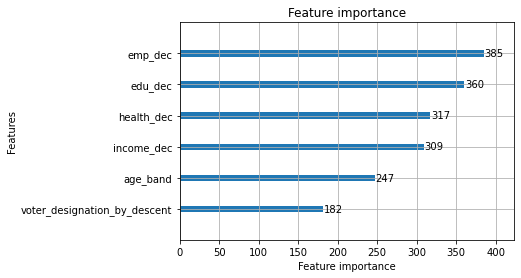

In [283]:
# feature importance - different to above as this at number of splits in model (I think?), 
# whereas above is contribution of features to final prediction value
lgb.plot_importance(lgb_mod, importance_type="split")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

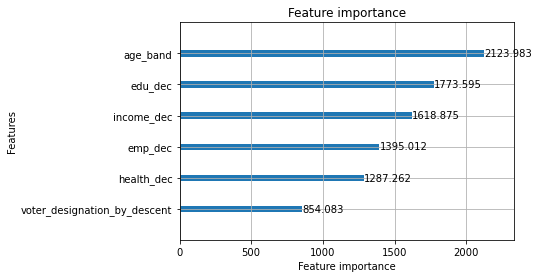

In [284]:
lgb.plot_importance(lgb_mod, importance_type="gain")

In [285]:
# output feature contributions
# TO DO: add these to rest of output table + write to file
d_preds = lgb_mod.predict(d_train[l_all], pred_contrib=True)

<AxesSubplot:title={'center':'Split value histogram for feature with name edu_dec'}, xlabel='Feature split value', ylabel='Count'>

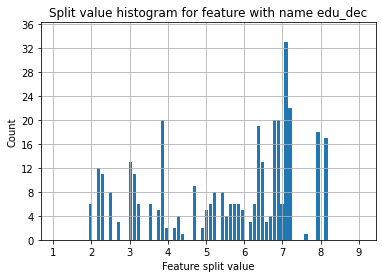

In [286]:
# not really useful but interesting helper plot
lgb.plot_split_value_histogram(lgb_mod, feature ='edu_dec')

<AxesSubplot:>

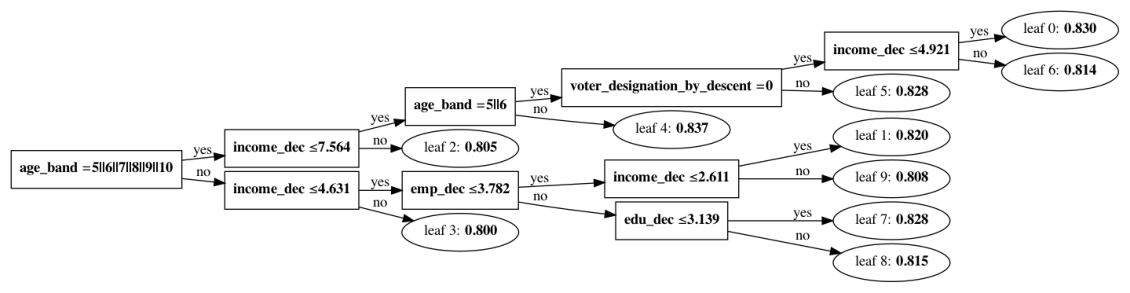

In [287]:
# not really useful but interesting helper plot
lgb.plot_tree(lgb_mod, tree_index = 0, figsize=(20,10))

In [288]:
# Useful tuning plot - doesn't work though??
#lgb.plot_metric(lgb_mod)

In [289]:
# view full table incl raw data, preds and error
qgrid.show_grid(d_out, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

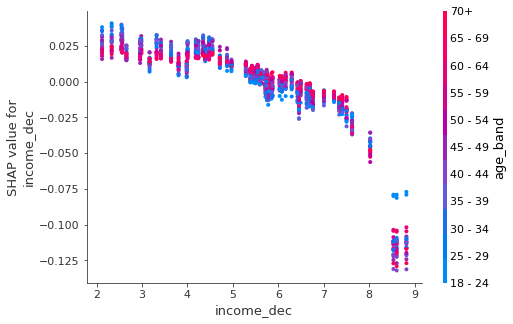

In [290]:
# shows the 2d dependency between variables - this shows age affects switch as income goes from high to low
shap.dependence_plot("income_dec", shap_values, d_train[l_all])

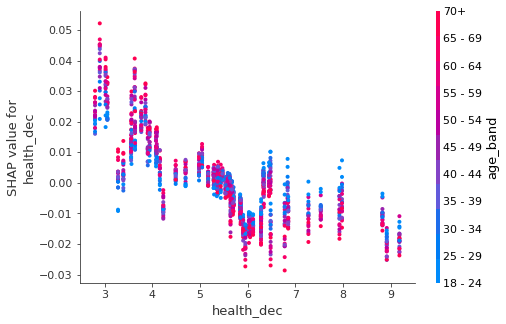

In [291]:
shap.dependence_plot("health_dec", shap_values, d_train[l_all])

In [292]:
qgrid.show_grid(d_out, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [293]:
d_train_out = d_train[l_all] #pandas getting me good, TO DO: tidy this 

In [294]:
#SHAP for individual observations - this is the money plot to show the interpendence between factors
i_selector = 0 # choose a row in training set, AKL Central/18-24/non-maori
# TO DO: Add a title based on the row selected (e.g. Electorate/Ethnicity etc)
shap.force_plot(
    base_value = n_average_turnout,
    shap_values = shap_values[i_selector],
    features = d_train_out.iloc[i_selector,:],
    feature_names = l_all
)

In [295]:
i_selector = 440 # think this is mangere/18-24/non-maori
shap.force_plot(
    base_value = n_average_turnout,
    shap_values = shap_values[i_selector],
    features = d_train_out.iloc[i_selector,:],
    feature_names = l_all
)

In [297]:
i_selector = 441 # think this is mangere/18-24/maori
shap.force_plot(
    base_value = n_average_turnout,
    shap_values = shap_values[i_selector],
    features = d_train_out.iloc[i_selector,:],
    feature_names = l_all
)